<a target="_blank" href="https://colab.research.google.com/github/erb24/thermomaps-gayberne/blob/main/thermomaps_GB.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [1]:
# install libraries for Google Colab
# skip this cell if running locally and the thermomaps-gayberne
# repository has already been installed
!git clone https://github.com/erb24/thermomaps-gayberne.git
!pip install -r thermomaps-gayberne/thermomaps-root/requirements.txt
!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
!pip install -e thermomaps-gayberne/thermomaps-root/.
!pip install jupyter matplotlib

Cloning into 'thermomaps-gayberne'...
remote: Enumerating objects: 741, done.
remote: Counting objects: 100% (109/109), done.
remote: Compressing objects: 100% (57/57), done.
remote: Total 741 (delta 77), reused 58 (delta 52), pack-reused 632 (from 1)
Receiving objects: 100% (741/741), 845.99 MiB | 16.62 MiB/s, done.
Resolving deltas: 100% (364/364), done.
Updating files: 100% (115/115), done.
Looking in indexes: https://download.pytorch.org/whl/cu118
Obtaining file:///content/thermomaps-gayberne/thermomaps-root
  Preparing metadata (setup.py) ... done
  Running setup.py develop for thermomaps
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 98.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.7/76.7 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.7/59.7 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 73.6 MB/s eta 0:00:00


In [8]:
# change into the root directory to load the libraries
import os
os.chdir('/content/thermomaps-gayberne/thermomaps-root/')
!pwd

/content/thermomaps-gayberne/thermomaps-root


In [9]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from ising.observables import Energy, Magnetization
from ising.samplers import SwendsenWangSampler, SingleSpinFlipSampler
from ising.base import IsingModel

from data.trajectory import EnsembleTrajectory, MultiEnsembleTrajectory
from data.dataset import MultiEnsembleDataset
from data.generic import Summary

from tm.core.prior import GlobalEquilibriumHarmonicPrior, UnitNormalPrior
from tm.core.backbone import ConvBackbone
from tm.core.diffusion_model import DiffusionTrainer, SteeredDiffusionSampler
from tm.core.diffusion_process import VPDiffusion
from tm.architectures.unet_2d_mid_attn import Unet2D
from tm.architectures.unet_1d import Unet1D

# extra libraries I am importing to implement the kludge
from data.observables import Observable
from sklearn.model_selection import ShuffleSplit
from tm.core.loader import Loader

First we simulate the Ising model over a range of temperatures, recording a `trajectory` consisting of lattice configurations. These trajectories are then aggregated into a `MultiEnsembleDataset` (i.e. many trajectories gathered under different thermodynamic ensembles).

In [10]:
# change into the analysis directory for analysis
os.chdir('/content/thermomaps-gayberne/analysis/')
!pwd

/content/thermomaps-gayberne/analysis


In [11]:
trajectories = []
for temperature in [0.2, 0.5, 1.0, 1.2, 1.5, 1.7, 1.8, 1.9, 2.0, 2.2, 2.4]:
    IM = IsingModel(sampler=SingleSpinFlipSampler, size = 8, warmup = 1000, temp = np.round(temperature,1), Jx = 1, Jy = 1)
    tmp = np.load('%sT/orientations.npy' % temperature)[1000:,:320,:]
    IM.trajectory.coordinates = tmp
    IM.trajectory.summary.size = 320
    IM.trajectory.summary.name = 'Gay-Berne'
    #nrg = np.load('%sT/e.npy' % temperature)
    mag = np.zeros(tmp.shape[0])
    for k in range(tmp.shape[0]):
        Q = np.matmul(tmp[k].T, tmp[k]) / tmp.shape[1] - (1/3) * np.eye(3)
        eigvals, _ = np.linalg.eigh(Q)
        mag[k] = 1.5 * np.max(eigvals)
    #IM.trajectory.observables['energy'] = nrg
    IM.trajectory.observables['magnetization'] = mag
    trajectories.append(IM.trajectory)
dataset = MultiEnsembleDataset(trajectories, Summary())


Each of the trajectories has a `Summary` object attached to it, which is just a `dict` containing metadata about the trajectory. If the summaries associated with all the trajectories in the `MultiEnsembleDataset` all have the same keys, the contents of the `MultiEnsembleDataset` can be conveniently cast as a pandas dataframe.

In [12]:
df = dataset.to_dataframe()
print(df)

    index       name  size  temperature  Jx  Jy     sampler
0       0  Gay-Berne   320          0.2   1   1  SingleSpin
1       1  Gay-Berne   320          0.5   1   1  SingleSpin
2       2  Gay-Berne   320          1.0   1   1  SingleSpin
3       3  Gay-Berne   320          1.2   1   1  SingleSpin
4       4  Gay-Berne   320          1.5   1   1  SingleSpin
5       5  Gay-Berne   320          1.7   1   1  SingleSpin
6       6  Gay-Berne   320          1.8   1   1  SingleSpin
7       7  Gay-Berne   320          1.9   1   1  SingleSpin
8       8  Gay-Berne   320          2.0   1   1  SingleSpin
9       9  Gay-Berne   320          2.2   1   1  SingleSpin
10     10  Gay-Berne   320          2.4   1   1  SingleSpin


The dataframe representation is especially powerful for creating subsets of a `MultiEnsembleDataset`. In this cell we extract a sub-dataframe containing trajectories at temperatures `T=1.0` and `T=2.0`. The sub-dataset can be initialized from the restricted dataframe.

**Our training data is going to be 5,000 samples from two temperatures (total of 10,000 samples) asymetrically spaced about the critical temperature $T_c$**

In [13]:
sub_df = df[df['temperature'].isin([1.0,2.0])]
sub_dataset = dataset.from_dataframe(sub_df)
print(sub_df)

   index       name  size  temperature  Jx  Jy     sampler
2      2  Gay-Berne   320          1.0   1   1  SingleSpin
8      8  Gay-Berne   320          2.0   1   1  SingleSpin


Here we extract the relevant observables for the Gay-Berne melt from each temperature in the dataset and plot the distribution of magnetization and energy as a function of temperature.

In [14]:
# skip the plots of the energy since the GB potential is not a function of spin state alone
# but also depends on the relative distance between ellipsoids...this is the difference between
# the GB model and the a lattice Ising model
simulated_M_v_T_mean = {t.state_variables['temperature']: t.observables['magnetization'].mean() for t in dataset.trajectories}
simulated_M_v_T_std = {t.state_variables['temperature']: t.observables['magnetization'].std() for t in dataset.trajectories}
train_M_v_T = {traj.state_variables['temperature']: simulated_M_v_T_mean[traj.state_variables['temperature']] for traj in sub_dataset.trajectories}

/tmp/ipython-input-113096736.py:25: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax2.legend()


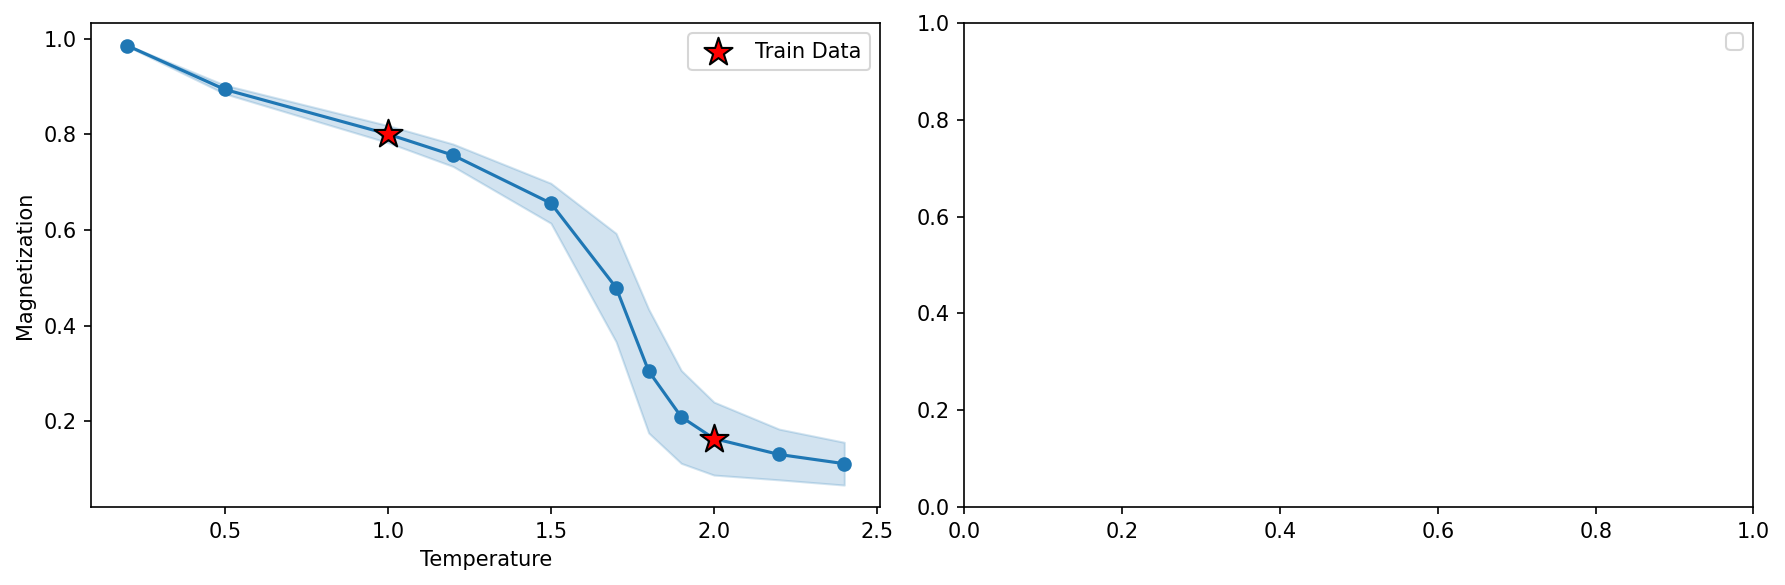

In [15]:
# Vary these to view different trajectories/configurations
trajectory_idx = -1
frame = -1

default_blue = plt.rcParams['axes.prop_cycle'].by_key()['color'][0]
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4), dpi=150)
ax1.plot(list(simulated_M_v_T_mean.keys()), list(simulated_M_v_T_mean.values()), c=default_blue)
ax1.scatter(list(simulated_M_v_T_mean.keys()), list(simulated_M_v_T_mean.values()), c=default_blue)
ax1.scatter(list(train_M_v_T.keys()), list(train_M_v_T.values()),
            c='r', marker='*', edgecolors='k', s=200, zorder=2, label='Train Data')
ax1.fill_between(list(simulated_M_v_T_mean.keys()),
                 [max(m - s, 0) for m, s in zip(simulated_M_v_T_mean.values(), simulated_M_v_T_std.values())],
                 [min(m + s, 1) for m, s in zip(simulated_M_v_T_mean.values(), simulated_M_v_T_std.values())],
                 alpha=0.2, color=default_blue)
ax1.set_ylabel('Magnetization')
ax1.set_xlabel('Temperature')


#img = ax3.imshow(trajectories[-1].coordinates[-1], aspect='equal', cmap='binary')
#ax3.set_title(f'Frame {range(len(trajectories[trajectory_idx].coordinates))[frame]} of sim. traj. at T = {trajectories[trajectory_idx].state_variables["temperature"]}')
#ax3.set_xticks([])
#ax3.set_yticks([])

ax1.legend()
ax2.legend()
plt.tight_layout()
plt.show()

In [16]:
# no fluctuations; just a single, averaged observable calculated over the simulation trajectory
for traj in sub_dataset.trajectories:
    print(traj.state_variables['temperature'])

1.0
2.0


In [17]:
# re-order the data

orientations_list = []
for temperature in [1.0, 2.0]: #[0.2, 0.5, 1.0, 1.2, 1.5, 1.7, 1.8, 1.9, 2.0, 2.2, 2.4]:
    orientations_list.append(np.load('%sT/orientations.npy' % temperature)[1000:,:320,:])
orientations = np.concatenate(orientations_list)


data = np.zeros((orientations.shape[0], orientations.shape[1], orientations.shape[2] + 1))
data[:,:,:3] = orientations
temperatures = np.array([1.0, 2.0]) #np.array([0.2, 0.5, 1.0, 1.2, 1.5, 1.7, 1.8, 1.9, 2.0, 2.2, 2.4])
T_list = np.zeros(data.shape[0])
for i in range(len(temperatures)):
    T_list[len(T_list) // len(temperatures) * (i):len(T_list) // len(temperatures) * ((i+1))] = temperatures[i]

data[:,:,-1] += T_list[:,None]

data = data.transpose(0, 2, 1)

# Verify the new shape
print(data.shape)

trajectory={'coordinate':[],'state_variables':[]}

trajectory['coordinate'] = data #orientations.transpose(0, 2, 1)
trajectory['state_variables'] = T_list

(18000, 4, 320)


Loaders for ThermoMap data can also be constructed from a `MultiEnsembleDataset`. The coordinates of the trajectory object are joined with the specified `state_variables` along the channel dimension.

In [18]:
train_loader = Loader(data=trajectory['coordinate'], temperatures=trajectory['state_variables'][:, None], control_dims=(3,4))#, **TMLoader_kwargs)
print(train_loader.num_dims, train_loader.num_channels)

3 4


/content/thermomaps-gayberne/thermomaps-root/tm/core/loader.py:298: UserWarning: Using a non-tuple sequence for multidimensional indexing is deprecated and will be changed in pytorch 2.9; use x[tuple(seq)] instead of x[seq]. In pytorch 2.9 this will be interpreted as tensor index, x[torch.tensor(seq)], which will result either in an error or a different result (Triggered internally at /pytorch/torch/csrc/autograd/python_variable_indexing.cpp:306.)
  self.unstd_control = self.data[self.control_slice][self.batch_slice]
/content/thermomaps-gayberne/thermomaps-root/tm/core/loader.py:299: UserWarning: Using a non-tuple sequence for multidimensional indexing is deprecated and will be changed in pytorch 2.9; use x[tuple(seq)] instead of x[seq]. In pytorch 2.9 this will be interpreted as tensor index, x[torch.tensor(seq)], which will result either in an error or a different result (Triggered internally at /pytorch/torch/csrc/autograd/python_variable_indexing.cpp:306.)
  self.std_control = self

Here we initialize the components of the ThermoMap algorithm.

First, we initialize the prior distribution that samples from the dataset will be mapped onto. The `GlobalEquilibriumHarmonicPrior` (`GEHP`) implements the temperature scaling at the core of the ThermoMap algorithm. We view the prior distribution as the equilibrium distribution arising from dynamics of a *physical* prior system. The `GEHP` assumes that the prior system is a particle in a harmonic trap, which results in a Normal equilibrium distribution whose variance is proportional to temperature.

I have also provided a `UnitNormalPrior` (`UNP`) which is a drop-in replacement for the `GEHP` that does not include any temperature rescaling. As such, a ThermoMap trained with a `UNP` is a standard diffusion model.

The prior requires the shape of the training data as input as well as the channels that are associated with coordinates and fluctuations (i.e. temperatures). The coordinate dimensions are sampled from a Normal distribution with variance determined by the fluctuation dimensions, while the fluctuation channels are sampled from a unit Normal distribution.

In [19]:
prior = GlobalEquilibriumHarmonicPrior(shape=train_loader.data.shape, channels_info={"coordinate": [0,1,2], "fluctuation": [3]})

The `model` is the black-box that is used to parameterize the score. Here we opt for a 2D U-net with attention at the upsampling/downsampling bottleneck.

In [20]:
model = Unet1D(dim=16, dim_mults=(1, 2, 4, 8), resnet_block_groups=8, channels=4)

The `backbone` is a wrapper around the model which contains the optimizer, scheduler, and other utilities and implements saving and loading the `model`.

In [21]:
# set the learning rate as a constant
DUMMY0 = 1e-3
backbone = ConvBackbone(model=model,
                        data_shape=train_loader.data_dim,
                        target_shape=320,
                        num_dims=3,
                        lr=DUMMY0,
                        eval_mode="train",
                       interpolate=False)

The `diffusion` instantiates the noise schedule, and implements the forward and reverse transition kernels of the diffusion process. Functionally, the `diffusion` implements the Euler-Maryuma SDE/Euler ODE solver for the variance-preserving diffusion process.

In [22]:
diffusion = VPDiffusion(num_diffusion_timesteps=100)

The `trainer` implements the training algorithm, consisting of sampling noise from the `prior`, calls to the transition kernels of the `diffusion`, and parameterizing the `backbone` to match the score.

In [23]:
trainer = DiffusionTrainer(diffusion,
                           backbone,
                           train_loader,
                           prior,
                           model_dir="./models/", # save models every epoch
                           pred_type="noise" #, # set to "noise" or "x0"
                           #test_loader=test_loader # optional
                           )

In [25]:
# set the number of training steps and the batch size as constants
NSTEP = 100
DUMMY1 = 5000
trainer.train(NSTEP, loss_type="smooth_l1", batch_size=DUMMY1)

OutOfMemoryError: CUDA out of memory. Tried to allocate 196.00 MiB. GPU 0 has a total capacity of 14.74 GiB of which 162.12 MiB is free. Process 6810 has 14.58 GiB memory in use. Of the allocated memory 14.39 GiB is allocated by PyTorch, and 70.56 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

The `sampler` is similar to the `trainer`, but rather than calling the $p(x_0|x_t)$ kernel, the `sampler` iteratively calls the $p(x_{t-1}|x_t)$ kernel.

In [26]:
sampler = SteeredDiffusionSampler(diffusion,
                                  backbone,
                                  train_loader,
                                  prior,
                                  pred_type='noise', # must be the same as in DiffusionTrainer
                                  )

With our trained model, we generated samples at a range of different temperatures, store the coordinates in an `EnsembleTrajectory` object, and evaluate observables over the coordinates of the trajectory. Note that there is no temporal order between points in the trajectory, as was the case of the Ising simulator.

In [27]:
# write the trained TM model to file
MODEL_NAME = "model"
backbone.save_state(MODEL_NAME, NSTEP)

In [28]:
trajectories = []
pbar = tqdm([0.2, 0.5, 1.0, 1.2, 1.5, 1.7, 1.8, 1.9, 2.0, 2.2, 2.4])
for temperature in pbar:
  pbar.set_description(f"Generating at T={temperature:.1f}")
  samples = sampler.sample_loop(num_samples=10000, batch_size=10000, temperature=temperature)
  coords = samples[:,:-1,:].numpy() # take coordinate dimension
  # normalize
  coords = coords / np.linalg.norm(coords, axis = 1)[:, None,:]

  # store in trajectory
  trajectory = EnsembleTrajectory(summary=Summary(info="Generated trajectory"),
                                  state_variables=Summary(temperature=temperature),
                                  coordinates=coords)

  mag = np.zeros(coords.shape[0])
  # evaluate observables over trajectory coordinates and add to trajectory object
  for k in range(coords.shape[0]):
      Q = np.matmul(coords[k], coords[k].T) / coords.shape[2] - (1/3) * np.eye(3)
      eigvals, _ = np.linalg.eigh(Q)
      mag[k] = 1.5 * np.max(eigvals)

  test = Magnetization()
  test.set(mag)
  trajectory.add_observable(test)
  trajectories.append(trajectory)

Generating at T=0.2:   0%|          | 0/11 [00:01<?, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 196.00 MiB. GPU 0 has a total capacity of 14.74 GiB of which 112.12 MiB is free. Process 6810 has 14.63 GiB memory in use. Of the allocated memory 14.43 GiB is allocated by PyTorch, and 71.70 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [29]:
# save the calculation order parameter and sampled structures to file
np.save(MODEL_NAME + 'magnetization.npy', np.array([(t.state_variables['temperature'], t.observables['magnetization'].quantity.mean(), t.observables['magnetization'].quantity.std()) for t in trajectories]))
np.save(MODEL_NAME + '_samples.npy', np.array([(t.observables['magnetization'].quantity) for t in trajectories]))

In [ ]:
# use the notebooks and scripts in the "analysis" directory for further analysis of the results